# Vision Transformer for Classification Example
## Chapter 3 Module 3

Now that we are aquainted with Transformers and FiftyOne, we can make our first go at using a Transformer on a dataset. We are going to jump right in with a sample of [Imagenet](https://www.image-net.org/) and the [ViT](https://huggingface.co/google/vit-base-patch16-224).

## Loading a Dataset

In [1]:
import fiftyone as fo
import fiftyone.zoo as foz 

dataset = foz.load_zoo_dataset(
    "imagenet-sample",
    dataset_name="imagenet-sample", #"Imagenet-Sample",
    max_samples=50,
    shuffle=True,
    overwrite=True,
)
session = fo.launch_app(dataset)

/opt/.fiftyone-venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Overwriting existing directory '/fiftyone/zoo/datasets/imagenet-sample'
 100% |████|  762.4Mb/762.4Mb [3.3s elapsed, 0s remaining, 221.7Mb/s]      
Extracting dataset...
Parsing dataset metadata
Found 1000 samples
Dataset info written to '/fiftyone/zoo/datasets/imagenet-sample/info.json'
Loading 'imagenet-sample'
 100% |███████████████████| 50/50 [45.8ms elapsed, 0s remaining, 1.1K samples/s]   
Dataset 'imagenet-sample' created


In [ ]:
foz.delete_zoo_dataset("imagenet-sample")

## Running Inference with the Help of FiftyOne

You can remember from last chapter ...

In [2]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224"
)
dataset.apply_model(model, label_field="ViT_predictions")



session.show()

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


 100% |███████████████████| 50/50 [44.2s elapsed, 0s remaining, 2.2 samples/s]      


## Running Inference Manually

We will show how to leverage FiftyOne dataset to help store all of our model predictions and allow us to visualize our results.

But this time we will do it ourselves!

Remember the pipeline almost always looks like:

1. Load your image
2. Preprocess your image
3. Inference on your image
4. Decode the prediction

Let's first start with just a single image from our dataset.

In [3]:
# Grab just the first image
sample = dataset.first()
print(sample)

# Get the image file path
filepath = sample.filepath
print(filepath)

<Sample: {
    'id': '688544cfb591cf4712554551',
    'media_type': 'image',
    'filepath': '/fiftyone/zoo/datasets/imagenet-sample/data/014102.jpg',
    'tags': [],
    'metadata': None,
    'created_at': datetime.datetime(2025, 7, 26, 21, 12, 47, 41000),
    'last_modified_at': datetime.datetime(2025, 7, 26, 21, 14, 36, 207000),
    'ground_truth': <Classification: {
        'id': '688544cfb591cf4712554550',
        'tags': [],
        'label': 'tiger cat',
        'confidence': None,
        'logits': None,
    }>,
    'ViT_predictions': <Classification: {
        'id': '6885453cb591cf47125545b7',
        'tags': [],
        'label': 'tiger, Panthera tigris',
        'confidence': 0.7458018660545349,
        'logits': array([ 8.34023178e-01,  5.44998161e-02,  7.48815596e-01,  6.50288045e-01,
               -2.52098180e-02, -8.67954671e-01, -7.16049314e-01,  1.28028750e+00,
                1.49504852e+00,  1.19699681e+00,  8.15062940e-01, -2.89897136e-02,
               -6.49730146e-

In [10]:
from transformers import ViTForImageClassification
from transformers import ViTImageProcessor
from PIL import Image

# Load the matching processor
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

# Load a pretrained ViT model
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

# 1. Load our image for inference
image = Image.open(filepath)

# 2. Preprocess
inputs = processor(images=image, return_tensors="pt")

# 3. Run inference
outputs = model(**inputs)

# 4. Decode prediction
predicted_class_idx = outputs.logits.argmax(-1).item()
predicted_label = model.config.id2label[predicted_class_idx]

print(f"Predicted class: {predicted_label}")

Predicted class: tiger, Panthera tigris


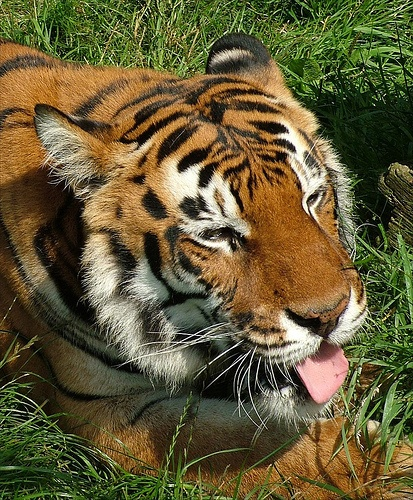

In [5]:
image

Now that we have that label, let's add it to our FiftyOne dataset!

In [11]:
sample["Manual_ViT_Predictions"] = fo.Classification(label=predicted_label)
sample.save()
print(sample.field_names)

('id', 'filepath', 'tags', 'metadata', 'created_at', 'last_modified_at', 'ground_truth', 'ViT_predictions', 'Manual_ViT_Predictions')


Now that it is saved to our dataset, we can view on our app to compare it to the ground truths!

In [12]:
session.show()

Now lets predict an entire dataset!

In [13]:
for sample in dataset:
    # 1. Load our image for inference
    image = Image.open(sample.filepath)

    # 2. Preprocess
    inputs = processor(images=image, return_tensors="pt")

    # 3. Run inference
    outputs = model(**inputs)

    # 4. Decode prediction
    predicted_class_idx = outputs.logits.argmax(-1).item()
    predicted_label = model.config.id2label[predicted_class_idx]

    # 5. Save the prediction to the sample
    sample["Manual_ViT_Predictions"] = fo.Classification(label=predicted_label)
    sample.save()

Ta da! We have now inferenced over an entire dataset! We can load images and inference in many ways:

In [ ]:
import cv2
import requests
from io import BytesIO

# Load from a file
image = Image.open("/workspaces/hands-on-introduction-to-transformers-for-computer-vision-4010343/Fireworks.jpg").convert("RGB")

# Load from a URL
url = "https://upload.wikimedia.org/wikipedia/commons/3/3a/Cat03.jpg"
response = requests.get(url)
image = Image.open(BytesIO(response.content)).convert("RGB")

# Open the default webcam (camera 0)
cap = cv2.VideoCapture(0)

ret, frame = cap.read()
cap.release()

if ret:
    # OpenCV loads in BGR — convert to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(frame_rgb)

    # Show the captured image
    image.show()
else:
    print("Failed to capture image from camera.")

In [17]:
import cv2
import requests
from io import BytesIO
from transformers import ViTForImageClassification
from transformers import ViTImageProcessor
from PIL import Image

# Load the matching processor
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

# Load a pretrained ViT model
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

# 1. Load our image for inference
image = Image.open("/workspaces/hands-on-introduction-to-transformers-for-computer-vision-4010343/Fireworks.jpg").convert("RGB")
# image = Image.open(filepath)
# url = "https://i.pinimg.com/originals/ae/15/40/ae154040cae718d2d422cf4f210a13b0.jpg"
# response = requests.get(url)
# image = Image.open(BytesIO(response.content)).convert("RGB")

# 2. Preprocess
inputs = processor(images=image, return_tensors="pt")

# 3. Run inference
outputs = model(**inputs)

# 4. Decode prediction
predicted_class_idx = outputs.logits.argmax(-1).item()
predicted_label = model.config.id2label[predicted_class_idx]

print(f"Predicted class: {predicted_label}")

Predicted class: volcano


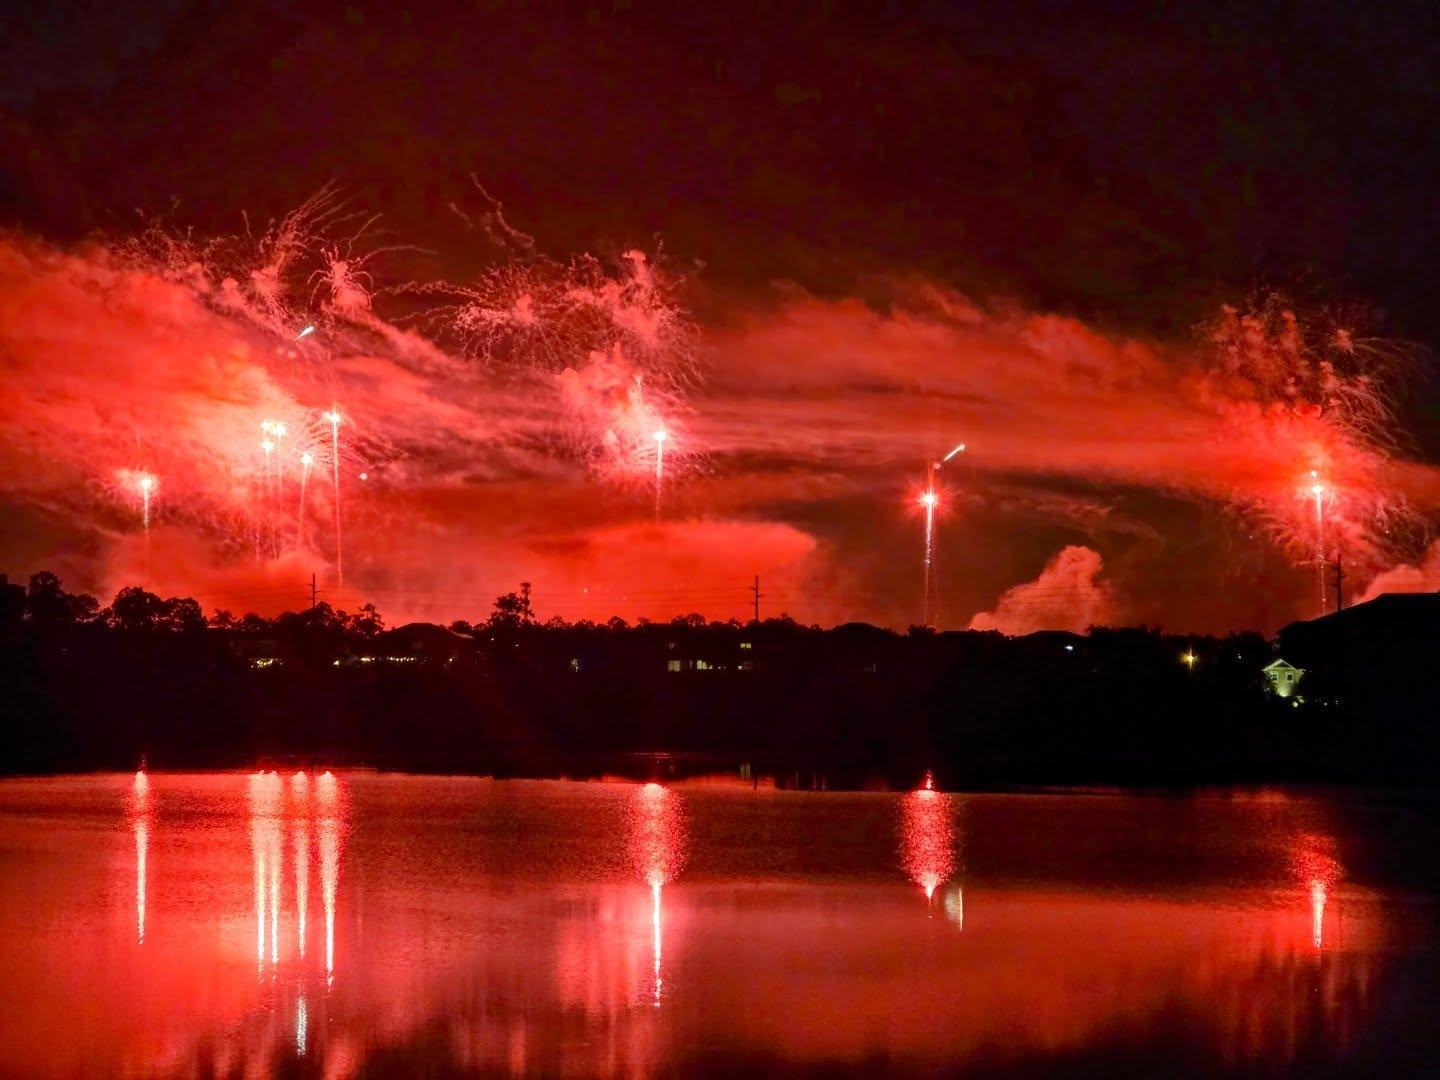

In [18]:
image